In [1]:
# 1D Heisenberg Model with periodic Boundary condition
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.sparse import csr_matrix, identity, kron 
from scipy.sparse.linalg import eigsh 
from numpy import linalg

This program aims at calculating the energy spectrum of 1D Heisenberg Chain with periodic bondary condition.

$\begin{equation}
H = J\sum_{i} \textbf{S}_{i} \textbf{S}_{i+1} = \frac{J}{2} \sum_{i} ( S^{+}_{i} S^{-}_{i+1} + S^{-}_{i} S^{+}_{i+1}) + J\sum_{i} S^{z}_{i} S^{z}_{i+1}
\end{equation}$

$\begin{equation}
S^{\pm} = S^{x} \pm i S^{y}
\end{equation}$

$\begin{equation}\
S^{x} = \frac{\hbar}{2} 
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} 
~~,~~ 
S^{y} = \frac{\hbar}{2} 
\begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix} 
~~,~~
S^{z} = \frac{\hbar}{2} 
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix} 
\end{equation}$




In [2]:
# Define the Operator, let hbar = 1 for simplicity
hbar = 1  

S_x = 0.5 * hbar * np.array([[0,1],[1,0]])
S_y = 0.5 * hbar * np.array([[0,-1j],[1j,0]])
S_z = 0.5 * hbar * np.array([[1,0],[0,-1]])

In [3]:
#Check the element of S_z to ensure we define the correct stuff 
S_z
val_z,vec_z = np.linalg.eig(S_z)
val_z, vec_z

(array([ 0.5, -0.5]),
 array([[1., 0.],
        [0., 1.]]))

In [4]:
#Similar to 1D Transverse Ising model, we need to define the operators in term of Direct Product Space: 
#Let define Sigma^{+} and Sigma^{-} first 
S_plus = S_x + 1j*S_y
S_minus = S_x - 1j*S_y

Impose the periodic boundary condition into the operators: 

Suppose I have a 1D chain and I impose the perodic boundary condition. Such periodic boundary condition map the chain into a ring, or we simply attach the start point and end point together. Consider the interaction term on the end of the chain, says $i = L$. Based on the equation above, we can express the interaction as follow: 
\begin{equation}
\frac{J}{2} ( S^{+}_{L}S^{-}_{L+1} + S^{-}_{L}S^{+}_{L+1} ) + J S^{z}_{L}S^{z}_{L+1} 
\end{equation}

However, the elements $S^{+}_{L+1},S^{-}_{L+1}, S^{z}_{L+1}$ describe the $i = 1$ site in the chain since we connect the start point with the end point of the chain. Therefore, we can rewrite this as: 
\begin{equation}
\frac{J}{2} ( S^{+}_{L}S^{-}_{L+1} + S^{-}_{L}S^{+}_{L+1} ) + J S^{z}_{L}S^{z}_{L+1}  = \frac{J}{2} ( S^{+}_{L}S^{-}_{1} + S^{-}_{L}S^{+}_{1} ) + J S^{z}_{L}S^{z}_{1} 
\end{equation}

To achive the above expression in Python, we can use the modulus to compute it. Suppose the chain has $L$ sites. For $L + 1, L+2,.... ,L+n$ sites, they are just equivalent to $L = 1, 2, 3,..., n$ for $n \leq L$. Therefore, this makes an equivalence relation on the integer space: 
\begin{equation}
i = i ~ \text{mod} ~ L ~~,~~ \text{for i} ~ \in ~\mathbb{N} 
\end{equation}


In [98]:
def S_Plus(index): 
    return kron(identity(2**index), kron(S_plus, identity(2**(L-index - 1))))

def S_Minus(index):
    return kron(identity(2**index), kron(S_minus, identity(2**(L-index - 1))))

def S_Z(index): 
    return kron(identity(2**index), kron(S_z, identity(2**(L-index - 1))))

In [99]:
def S_PM(index): 
    return S_Plus(index) * S_Minus((index + 1) % L ) 

def S_MP(index):
    return S_Minus(index) * S_Plus((index + 1) % L ) 

def S_ZZ(index): 
    return S_Z(index) * S_Z((index + 1) % L)

In [52]:
# Define the Hamiltonian of Heisenberg Model w/ Periodic B.C.


def Hamiltonian(J): 
    H = 0 
    #L = number of sites 
    for i in range(L):
        H = H + 0.5 * J *  ( S_PM(i) +  S_MP(i) ) + J * S_ZZ(i)
    return H 



In [8]:
# The number of eigenvalues that we wanna extract 
N = 40

# The number of sites
L = 10

# The array of j ranging from 0 to 2 
hj = np.arange(0, 2, 0.02)

# Store the eigenvalue according to the value of hj
res = np.zeros((N,len(hj)))

for (i,j) in enumerate(hj):
    # val,vec = np.linalg.eig(Hamiltonian(1.0,h).toarray())
    val, vec = eigsh(Hamiltonian(j).toarray(), N , which="SA" , return_eigenvectors=True)
    res[:,i] = val 

In [ ]:
res_new = np.zeros(res.shape)
for i in range(N):
    res_new[i,:] = res[i,:] - res[0,:]
res_new.shape

In [ ]:
plt.title("Energy Spectrum of 1D Heisenberg Model ")
plt.plot(hj, np.transpose(res_new), ",b")
plt.ylabel(r"$E_{n} - E_{0}$")
plt.xlabel(r" $J$ ")
plt.xlim([0,2])
plt.ylim([-0.3,7])

In [ ]:
# For J < 0 case: 
L = 10
N = 40


hj_minus = np.arange(-2,0,0.02)

# Store the eigenvalue according to the value of hj
res_minus = np.zeros((N,len(hj_minus)))



for (i,j) in enumerate(hj_minus):
    # val,vec = np.linalg.eig(Hamiltonian(1.0,h).toarray())
    val, vec = eigsh(Hamiltonian(j).toarray(), N , which="SA" , return_eigenvectors=True)
    res_minus[:,i] = val 

In [ ]:
res_new_minus = np.zeros(res_minus.shape)
for i in range(N):
    res_new_minus[i,:] = res_minus[i,:] - res_minus[0,:]
res_new_minus.shape

In [ ]:
plt.title("Energy Spectrum of 1D Heisenberg Model ")
plt.plot(hj_minus, np.transpose(res_new_minus), ",b")
plt.ylabel(r"$E_{n} - E_{0}$")
plt.xlabel(r" $J$ ")
# plt.xlim([-2,0])
# plt.ylim([-0.3,7])

In [5]:
L_array = np.arange(2, 18, 2)
L_array

array([ 2,  4,  6,  8, 10, 12, 14, 16])

In [6]:
def S_Plus(index,L): 
    return kron(identity(2**index), kron(S_plus, identity(2**(L-index - 1))))

def S_Minus(index,L):
    return kron(identity(2**index), kron(S_minus, identity(2**(L-index - 1))))

def S_Z(index,L): 
    return kron(identity(2**index), kron(S_z, identity(2**(L-index - 1))))

def S_PM(index,L): 
    return S_Plus(index,L) * S_Minus((index + 1) % L,L ) 

def S_MP(index,L):
    return S_Minus(index,L) * S_Plus((index + 1) % L ,L) 

def S_ZZ(index,L): 
    return S_Z(index,L) * S_Z((index + 1) % L,L)

In [7]:
def Ham(J,L): 
    H = 0 
    #L = number of sites 
    for i in range(L):
        H = H + 0.5 * J *  ( S_PM(i,L) +  S_MP(i,L) ) + J * S_ZZ(i,L)
    return H

<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 6 stored elements in Compressed Sparse Row format>

In [8]:
def get_GS(L):
    J = 1 
    val, vec = eigsh(Ham(J,int(L)), 1 , which="SA" , return_eigenvectors=True)
    return val

In [9]:
get_GS(14)/14

array([-0.4473964])

In [10]:
GS_array = np.zeros(len(L_array))

for i in range(len(GS_array)):
    # print(L_array[i])
   GS_array[i] = get_GS(L_array[i]) *  float(L_array[i])**-1


In [11]:
np.save("GS_array_BF", GS_array)

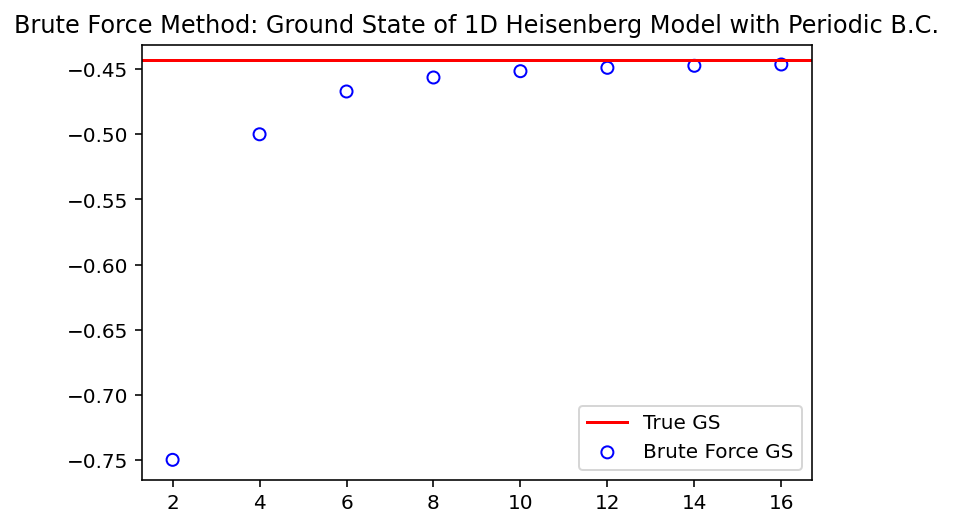

In [12]:
plt.title("Brute Force Method: Ground State of 1D Heisenberg Model with Periodic B.C.")
plt.scatter(L_array, GS_array,facecolors='none', edgecolors='b' ,label=r"Brute Force GS" )
plt.axhline(y=-np.log(2) + 0.25, color='r', linestyle='-', label=r"True GS")
plt.legend()